# "Zillow Zing Zestimate Project"

## Background

*Zillow is an online real estate database company founded in 2006 - Wikipedia.* “Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today). The Zillow Zestimate Zing Project will predict the error between Zestimate and the sales price of a home. 

- Project By `Ednalyn C. De Dios`
- Codeup Data Science
- ADA Cohort
- 25 March 2019

## Project Planning

### Goals

- Determine variables that drive log errors.
- Develop a linear regression model that will best predict the log errors.

### Deliverables

1. Report
1. Jupyter Notebook

### Data Dictionary & Details


***We will be using 2016 data.***

- logerror: log function of the error between Zestimate and sale price of a home.
- bathroomcnt:  Number of bathrooms in home including fractional bathrooms.
- bedroomcnt:  Number of bedrooms in home.
- calculatedfinishedsquarefeet:  Calculated total finished living area of the home.
- fullbathcnt:  Number of full bathrooms (sink, shower + bathtub, and toilet) present in home.
- garagecarcnt:  Total number of garages on the lot including an attached garage.
- roomcnt:  Total number of rooms in the principal residence.
- yearbuilt:  The Year the principal residence was built.
- taxvalueddollarcnt: The total tax assessed value of the parcel.
- taxamount: The total property tax assessed for that assessment year.

### Initial Thoughts, Ideas, Hypotheses

- *TODO: fill this out.*

### Preparing the Environment

Libraries imported below for data wrangling, exploring, visualizing, and modeling will be used throughout the project.

In [1]:
# Wrangling
import pandas as pd
import math
import numpy as np

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# Modeling
import statsmodels.api as sm

from scipy.stats import pearsonr, ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.feature_selection import f_regression

from env import user, host, password, path

#### Utilities
*TODO: Functions to export in the `util.py` later.*

In [2]:
def summarize_df(df):
    print("Summary of Data\n")
    print("Rows & Columns:\n")
    print(df.shape)
    print("Variables:\n")
    var_names = df.columns.values
    print(var_names)
    print("\nColumn Info:\n")
    print(df.info())
    print("\nNumeric Summary Stats:\n")
    print(df.describe())
    print("\nTop 5 Values:\n")
    for var in var_names:
        print(var+":")
        print(df[var].value_counts().head())
        print('\n')
    print("\nMissing Values:\n")
    null_counts = df.isnull().sum()
    if len(null_counts[null_counts > 0]) == 0:
        print("No missing values")
    else:
        print(null_counts[null_counts > 0])
    print("\nFirst 5 rows:\n")
    print(df.head())
    print("\nEnd of Summary")

def validate_tts(X_train, y_train, X_test, y_test):
    if X_train.shape[0] == y_train.shape[0]:
        print("X & y train rows ARE equal")
    else:
        print("X & y train rows ARE NOT equal")


    if X_test.shape[0] == y_test.shape[0]:
        print("X & y test rows ARE equal")
    else:
        print("X & y test rows ARE NOT equal")

    if train.shape[1] == test.shape[1]:
        print("Number of columns in train & test ARE equal")
    else:
        print("Number of columns in train & test ARE NOT equal")

    train_split = train.shape[0] / (train.shape[0] + test.shape[0])
    test_split = test.shape[0] / (train.shape[0] + test.shape[0])

    print("Train Split: %.2f" % train_split)
    print("Test Split: %.2f" % test_split)

### Data Acquisition

- Acquire the data via csv files.
- Generate cohesive dataset with recommended columns.


In [3]:
# Acquire the data via csv
train_df = pd.read_csv(path+"train_2016_v2.csv", low_memory=False)
properties_df = pd.read_csv(path+"properties_2016.csv", low_memory=False)

# Generate a cohesive dataset
df = pd.merge(train_df, properties_df, on='parcelid', how='inner')
df = df[['logerror',
         'bathroomcnt',
         'bedroomcnt',
         'calculatedfinishedsquarefeet',
         'fullbathcnt',
         'garagecarcnt',
         'roomcnt',
         'yearbuilt',
         'taxvaluedollarcnt',
         'taxamount'
        ]]

Log errors were filtered organically after merging.

In [4]:
# Check for null values in the columns
print(df.isnull().sum())

# Check number of rows and columns after merging
df.shape

logerror                            0
bathroomcnt                         0
bedroomcnt                          0
calculatedfinishedsquarefeet      661
fullbathcnt                      1182
garagecarcnt                    60338
roomcnt                             0
yearbuilt                         756
taxvaluedollarcnt                   1
taxamount                           6
dtype: int64


(90275, 10)

#### Discard unwanted columns.

In [5]:
# Remove these columns entirely due to high number of null and zero values
df = df.drop(['garagecarcnt', 'roomcnt'], axis=1)
df.sample(10)

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
16518,0.3090,2.0,3.0,2050.0,2.0,1978.0,226438.0,3299.63
12503,0.0535,2.0,2.0,1031.0,2.0,1989.0,256664.0,2618.82
58167,0.0129,3.0,3.0,2523.0,3.0,2005.0,240782.0,3866.78
75290,0.0723,2.5,1.0,1751.0,2.0,2005.0,427000.0,5565.82
48956,0.0060,2.0,4.0,1405.0,2.0,1978.0,351000.0,5006.12
79827,0.1638,5.5,6.0,5872.0,5.0,1988.0,1023530.0,10653.66
68481,-0.0151,3.0,4.0,2973.0,3.0,1993.0,764985.0,8814.42
69339,0.0109,3.0,4.0,2331.0,3.0,1966.0,591630.0,7110.56
73792,0.0344,2.0,4.0,2837.0,2.0,2000.0,388000.0,6062.81
36387,0.0159,2.0,2.0,1114.0,2.0,1990.0,423120.0,4742.72


Summarize the data using predefined function.

In [6]:
summarize_df(df)

Summary of Data

Rows & Columns:

(90275, 8)
Variables:

['logerror' 'bathroomcnt' 'bedroomcnt' 'calculatedfinishedsquarefeet'
 'fullbathcnt' 'yearbuilt' 'taxvaluedollarcnt' 'taxamount']

Column Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 8 columns):
logerror                        90275 non-null float64
bathroomcnt                     90275 non-null float64
bedroomcnt                      90275 non-null float64
calculatedfinishedsquarefeet    89614 non-null float64
fullbathcnt                     89093 non-null float64
yearbuilt                       89519 non-null float64
taxvaluedollarcnt               90274 non-null float64
taxamount                       90269 non-null float64
dtypes: float64(8)
memory usage: 6.2 MB
None

Numeric Summary Stats:

           logerror   bathroomcnt    bedroomcnt  calculatedfinishedsquarefeet  \
count  90275.000000  90275.000000  90275.000000                  89614.000000   
mean       0.01145

### Data Preparation

Our goal is to leave this section with a dataset that is ready to be analyzed. 

In [7]:
# Discard rows where respective column contains null
df = df[df['calculatedfinishedsquarefeet'].notnull()]
df = df[df['fullbathcnt'].notnull()]
df = df[df['yearbuilt'].notnull()]
df = df[df['taxvaluedollarcnt'].notnull()]
df = df[df['taxamount'].notnull()]

# Check for null values
print(df.isnull().sum())
df.sample(10)

logerror                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fullbathcnt                     0
yearbuilt                       0
taxvaluedollarcnt               0
taxamount                       0
dtype: int64


,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
4697,0.1337,3.0,3.0,1840.0,3.0,2002.0,563534.0,6712.64
27320,-0.1827,2.0,3.0,1427.0,2.0,1964.0,59069.0,988.82
53520,-0.0080,1.0,2.0,1367.0,1.0,1930.0,484489.0,6190.88
69445,0.0392,1.0,1.0,824.0,1.0,1926.0,277594.0,3599.22
3949,0.0070,3.0,3.0,1881.0,3.0,1992.0,126025.0,2363.11
76305,0.0998,4.0,5.0,2113.0,4.0,1946.0,209414.0,2685.82
42942,0.0020,2.5,3.0,1848.0,2.0,1977.0,848623.0,9644.82
11330,0.0060,1.5,1.0,1188.0,1.0,2005.0,675000.0,7710.48
19452,-0.0222,3.0,4.0,2298.0,3.0,1998.0,276000.0,5336.76
9093,-0.0408,1.0,1.0,936.0,1.0,1948.0,394473.0,4880.52


#### Create a variable, `colnames`, that is a list of the column names. 
We will likely reference this variable later.

In [8]:
colnames = ['logerror',
            'bathroomcnt',
            'bedroomcnt',
            'calculatedfinishedsquarefeet',
            'fullbathcnt',
            'yearbuilt',
            'taxvaluedollarcnt',
            'taxamount'
           ]
df.sample(10)

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
21683,0.2271,1.0,2.0,864.0,1.0,1947.0,296814.0,3938.99
83279,-0.2666,2.0,2.0,1198.0,2.0,1943.0,243914.0,3072.83
20137,-0.1278,2.0,2.0,1673.0,2.0,1993.0,704966.0,8569.73
28458,-0.1672,3.0,3.0,1190.0,3.0,2013.0,896562.0,10935.53
48638,-0.0954,2.5,4.0,3220.0,2.0,1981.0,925000.0,10987.82
38893,0.0392,1.0,3.0,1024.0,1.0,1953.0,342000.0,4220.06
54704,-0.0151,2.0,3.0,1574.0,2.0,1954.0,388597.0,4358.99
62491,-0.0040,2.0,3.0,1582.0,2.0,1951.0,115868.0,1532.45
18914,0.0080,2.5,3.0,1929.0,2.0,1994.0,603738.0,6409.76
60798,0.0315,3.0,4.0,2360.0,3.0,1990.0,348692.0,4437.46


#### Identify the data types of each variable. Why? 
We need to make sure they are what makes sense for the data and the meaning of the data that lies in that variable. If it does not, make necessary changes.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88998 entries, 0 to 90274
Data columns (total 8 columns):
logerror                        88998 non-null float64
bathroomcnt                     88998 non-null float64
bedroomcnt                      88998 non-null float64
calculatedfinishedsquarefeet    88998 non-null float64
fullbathcnt                     88998 non-null float64
yearbuilt                       88998 non-null float64
taxvaluedollarcnt               88998 non-null float64
taxamount                       88998 non-null float64
dtypes: float64(8)
memory usage: 6.1 MB


We still need to convert yearbuilt to integer and remove the trailing .0 as well.

In [10]:
# Convert from float to integer
df['yearbuilt'] = df['yearbuilt'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88998 entries, 0 to 90274
Data columns (total 8 columns):
logerror                        88998 non-null float64
bathroomcnt                     88998 non-null float64
bedroomcnt                      88998 non-null float64
calculatedfinishedsquarefeet    88998 non-null float64
fullbathcnt                     88998 non-null float64
yearbuilt                       88998 non-null int64
taxvaluedollarcnt               88998 non-null float64
taxamount                       88998 non-null float64
dtypes: float64(7), int64(1)
memory usage: 6.1 MB


In [11]:
df.sample(10)

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
3681,0.0198,3.0,4.0,2010.0,3.0,1986,606100.0,7072.17
18779,-0.0233,2.5,4.0,2148.0,2.0,1999,708288.0,7224.00
13495,-0.0101,2.0,2.0,820.0,2.0,1947,298575.0,4021.79
51951,0.0478,2.0,2.0,960.0,2.0,2006,165229.0,2143.20
62435,0.0247,2.5,4.0,2377.0,2.0,1976,698685.0,7747.94
27880,-0.0315,2.0,3.0,970.0,2.0,1989,197208.0,2775.34
13853,0.0620,3.0,4.0,2989.0,3.0,1990,741810.0,8900.48
64388,-0.0131,2.0,4.0,1491.0,2.0,1906,310725.0,4796.66
50241,-0.0608,2.0,4.0,1668.0,2.0,1958,647094.0,8068.56
77914,0.0402,2.5,2.0,1614.0,2.0,1980,356065.0,3602.00


#### Identify the columns that have missing values and the number of missing values in each column. 
Missing values are going to cause issues down the line so we will need to handle those appropriately. For each variable with missing values, if it makes sense to replace those missing with a 0, do so. For those where that doesn't make sense, decide if we should drop the entire observations (rows) that contain the missing values, or drop the entire variable (column) that contains the missing values.

In [12]:
# Check for null values
df.isnull().sum()

logerror                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fullbathcnt                     0
yearbuilt                       0
taxvaluedollarcnt               0
taxamount                       0
dtype: int64

#### Create a list of the independent variable names (aka attributes) and assign it to `x_vars` 
During exploration, we will likely use this list to refer to the attribute names.

In [13]:
x_vars = ['bathroomcnt',
          'bedroomcnt',
          'calculatedfinishedsquarefeet',
          'fullbathcnt',
          'yearbuilt',
          'taxvaluedollarcnt',
          'taxamount'
         ]

#### We need to clearly identify our dependent (target) variable. 
- `logerror` is our target variable, a continuous variable.

#### View the distribution of the numeric variables
- We will plot a histogram and box plot of each variable to see the distribution, skewness, outliers, and unit scales. We will use this information in our decision of whether to normalize, standardize or neither.

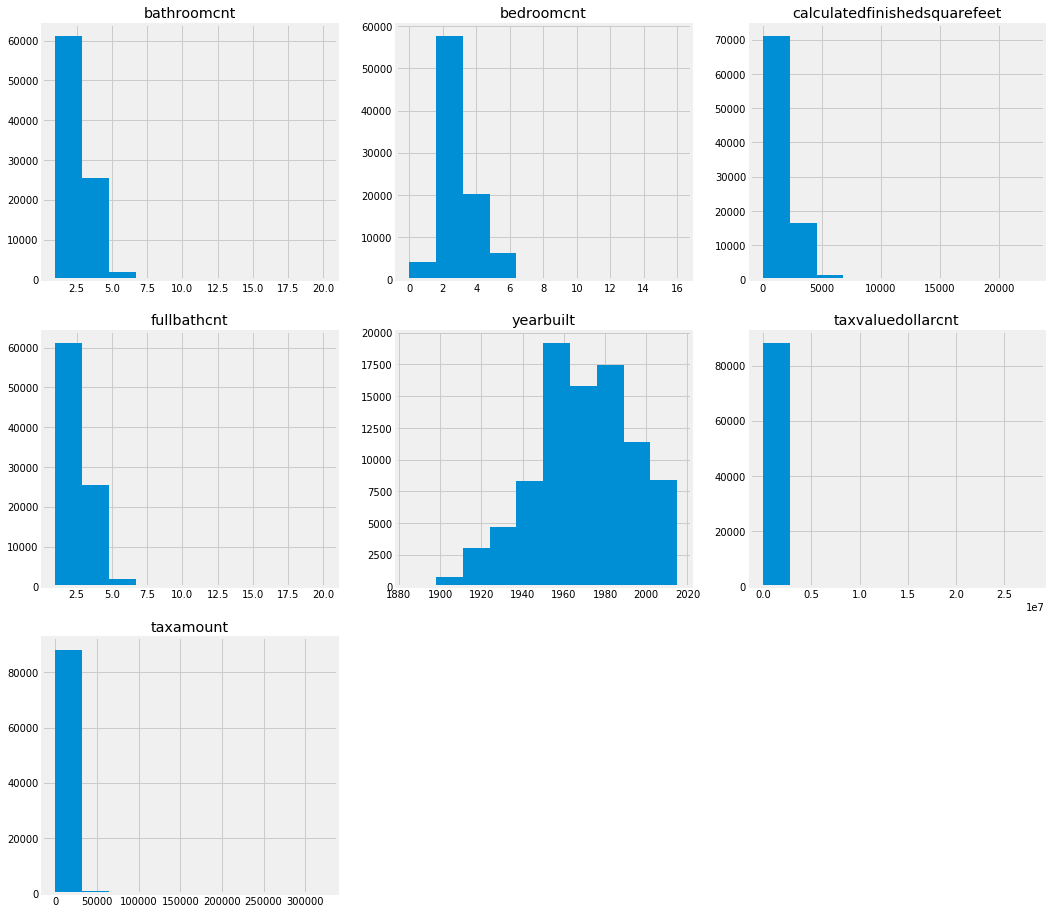

In [14]:
# Histogram
plt.figure(figsize=(16,16))
for i, col in enumerate(['bathroomcnt',
          'bedroomcnt',
          'calculatedfinishedsquarefeet',
          'fullbathcnt',
          'yearbuilt',
          'taxvaluedollarcnt',
          'taxamount'
         ]):
    plot_number = i + 1
    series = df[col]
    plt.subplot(3,3,plot_number)
    plt.title(col)
    series.hist()

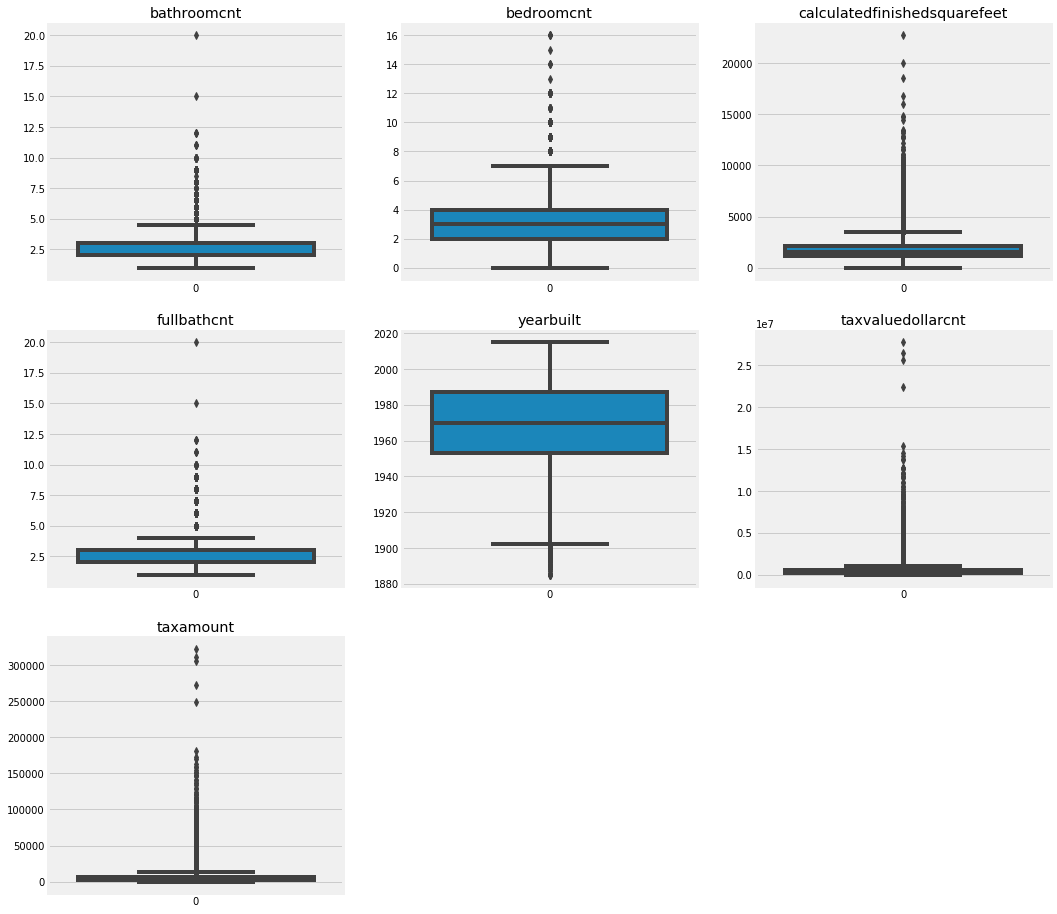

In [15]:
# Box plot
plt.figure(figsize=(16,16))
for i, col in enumerate(['bathroomcnt',
          'bedroomcnt',
          'calculatedfinishedsquarefeet',
          'fullbathcnt',
          'yearbuilt',
          'taxvaluedollarcnt',
          'taxamount'
         ]):
    plot_number = i + 1
    plt.subplot(3,3,plot_number)
    plt.title(col)
    sns.boxplot(data=df[col])

#### Discard unwated rows (observations).

In [16]:
# Remove outliers or nonsensical observations
df = df[df.bathroomcnt != 20]
df = df[df.taxvaluedollarcnt != 22.0]
df = df[df.taxamount >= 50]
df.sample(10)

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
8870,0.0334,1.0,1.0,696.0,1.0,1968,211000.0,2749.42
89189,0.0010,3.0,2.0,1310.0,3.0,2008,178000.0,4223.05
75978,-0.0429,3.0,4.0,2212.0,3.0,1955,485972.0,6236.99
51298,-0.0305,1.0,3.0,1350.0,1.0,1926,399477.0,4463.12
61943,0.0478,2.0,2.0,1400.0,2.0,1956,102312.0,8058.22
4489,-0.0090,2.0,3.0,1583.0,2.0,1957,68263.0,1041.70
30300,-0.0672,1.0,2.0,1082.0,1.0,1948,235937.0,5131.24
60174,0.0060,2.0,2.0,966.0,2.0,1971,253000.0,3362.66
82897,-0.2244,3.0,3.0,1336.0,3.0,1991,113935.0,1953.94
34547,-0.0131,2.5,3.0,1403.0,2.0,2005,287818.0,3380.14


Save the snippet below for the min max normalization later.

In [17]:
# std_df = df.drop(colnames, axis=1)

# std_df['log_error'] = df.logerror

# #std_df['bathroom_count'] = (df.bathroomcnt - df.bathroomcnt.min()) / (df.bathroomcnt.max() - df.bathroomcnt.min())
# std_df['bathroom_count'] = df.bathroomcnt
# #std_df['bathroom_count'] = (df.bedroomcnt - df.bedroomcnt.min()) / (df.bedroomcnt.max() - df.bedroomcnt.min())
# std_df['bedroom_count'] = df.bedroomcnt
# #std_df['square_feet'] = (df.calculatedfinishedsquarefeet - df.calculatedfinishedsquarefeet.min()) / (df.calculatedfinishedsquarefeet.max() - df.calculatedfinishedsquarefeet.min())
# std_df['square_feet'] = df.calculatedfinishedsquarefeet
# #std_df['full_bath_count'] = (df.fullbathcnt - df.fullbathcnt.min()) / (df.fullbathcnt.max() - df.fullbathcnt.min())
# std_df['full_bath_count'] = df.fullbathcnt
# #std_df['year_built'] = (df.yearbuilt - df.yearbuilt.min()) / (df.yearbuilt.max() - df.yearbuilt.min())
# std_df['year_built'] = df.yearbuilt
# #std_df['tax_value_count'] = (df.taxvaluedollarcnt - df.taxvaluedollarcnt.min()) / (df.taxvaluedollarcnt.max() - df.taxvaluedollarcnt.min())
# std_df['tax_value_count'] = df.taxvaluedollarcnt
# #std_df['tax_amount'] = (df.taxamount - df.taxamount.min()) / (df.taxamount.max() - df.taxamount.min())
# std_df['tax_amount'] = df.taxamount



In [18]:
# Just to be sure...
df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88995 entries, 0 to 90274
Data columns (total 8 columns):
logerror                        88995 non-null float64
bathroomcnt                     88995 non-null float64
bedroomcnt                      88995 non-null float64
calculatedfinishedsquarefeet    88995 non-null float64
fullbathcnt                     88995 non-null float64
yearbuilt                       88995 non-null int64
taxvaluedollarcnt               88995 non-null float64
taxamount                       88995 non-null float64
dtypes: float64(7), int64(1)
memory usage: 6.1 MB


,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
43137,-0.0010,1.0,2.0,602.0,1.0,1925,232000.0,4147.52
3343,0.0305,4.5,5.0,3139.0,4.0,2004,732343.0,12332.86
31042,0.0344,2.0,2.0,999.0,2.0,1952,299000.0,4598.74
47589,0.0050,3.0,3.0,1726.0,3.0,1987,440348.0,5436.27
80159,-0.1875,3.0,6.0,2777.0,3.0,1912,463709.0,5869.28
16873,-0.0651,2.0,3.0,1310.0,2.0,1985,376127.0,6545.12
20519,-0.0131,1.0,3.0,911.0,1.0,1954,409843.0,4890.52
63992,0.0344,1.0,3.0,1389.0,1.0,1949,63322.0,1516.15
47533,0.0554,3.0,3.0,2536.0,3.0,1948,887000.0,11927.93
89475,0.1398,2.0,3.0,1339.0,2.0,1988,59067.0,913.89


### Data Exploration

Our goal is to address each of the questions we posed in our planning & brainstorming through visual or statistical analysis.

When we complete this step, we will have the findings from our analysis that will be used in our final report, the answers to our questions and our customer's questions that will reach the goal. 

*The idea and code below were inspired and adapted from Sudalai Raj Kumar (SRK) at https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-zillow-prize .*

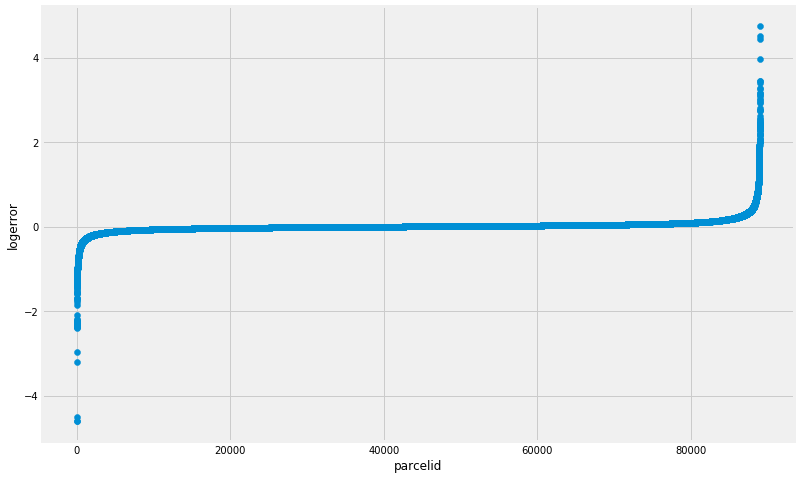

/Users/ddfloww/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


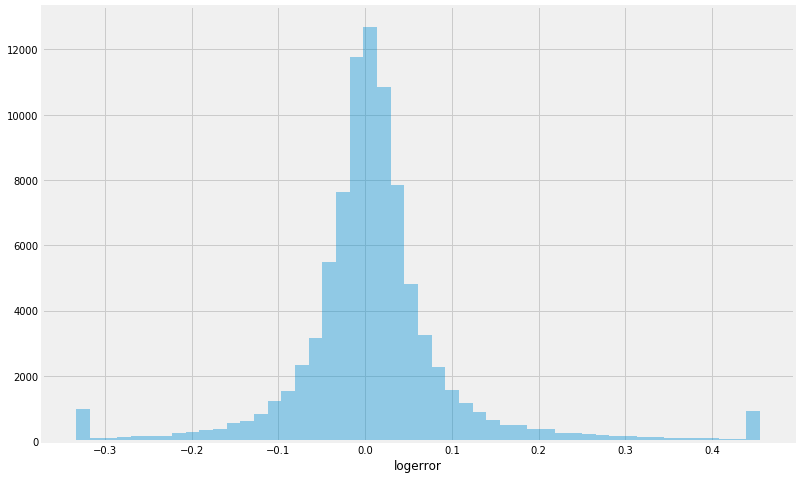

In [19]:
# Plot the log error
plt.figure(figsize=(12,8))
plt.scatter(range(df.shape[0]), np.sort(df.logerror.values))
plt.xlabel('parcelid')
plt.ylabel('logerror')
plt.show()

# Remove outliers
ulimit = np.percentile(df.logerror.values, 99)
llimit = np.percentile(df.logerror.values, 1)
df['logerror'].loc[df['logerror']>ulimit] = ulimit
df['logerror'].loc[df['logerror']<llimit] = llimit

# Plot the distribution
plt.figure(figsize=(12,8))
sns.distplot(df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror')
plt.show()

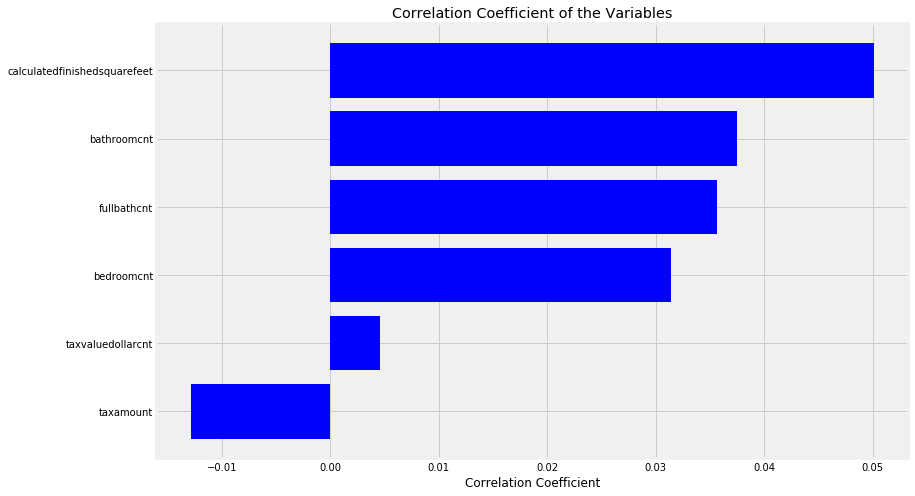

In [20]:
# Correlation coefficient of each of these variables
x_vars = [col for col in df.columns if col not in ['logerror'] if df[col].dtype=='float64']

labels = []
values = []
for col in x_vars:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df.logerror.values)[0,1])
correlation_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
correlation_df = correlation_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 1
fig, ax = plt.subplots(figsize=(12,8))
rects = ax.barh(ind, np.array(correlation_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(correlation_df.col_labels.values)
ax.set_xlabel("Correlation Coefficient")
ax.set_title("Correlation Coefficient of the Variables")
plt.show()

#### Split data into training and test datasets

In [21]:
# test_train_split
X = df.drop(['logerror'], axis=1)

print(X.head())

y = df[['logerror']]
print(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)

print()
print("Train columns:  %s" % list(train.columns))
print("Train dimensions (rows, columns):", train.shape)
print()

test = pd.concat([X_test, y_test], axis=1)

print("Test columns:  %s" % list(test.columns))
print("Test dimensions (rows, columns):", test.shape)
print()

validate_tts(X_train, y_train, X_test, y_test)

X.sample(10)

   bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  fullbathcnt  \
0          2.0         3.0                        1684.0          2.0   
1          3.5         4.0                        2263.0          3.0   
2          3.0         2.0                        2217.0          3.0   
3          2.0         2.0                         839.0          2.0   
4          2.5         4.0                        2283.0          2.0   

   yearbuilt  taxvaluedollarcnt  taxamount  
0       1959           360170.0    6735.88  
1       2014           585529.0   10153.02  
2       1940           119906.0   11484.48  
3       1987           244880.0    3048.74  
4       1981           434551.0    5488.96  
   logerror
0    0.0276
1   -0.1684
2   -0.0040
3    0.0218
4   -0.0050

Train columns:  ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'yearbuilt', 'taxvaluedollarcnt', 'taxamount', 'logerror']
Train dimensions (rows, columns): (71196, 8)

Test columns:  ['bat

/Users/ddfloww/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
82515,2.0,2.0,960.0,2.0,1968,190512.0,2427.02
77838,2.0,2.0,813.0,2.0,1986,397000.0,4661.52
54293,3.0,3.0,1666.0,3.0,1979,527000.0,6350.99
69712,2.0,3.0,1331.0,2.0,1953,383486.0,4783.44
40281,3.0,3.0,1667.0,3.0,2006,364000.0,5292.94
39143,3.0,3.0,1769.0,3.0,1947,556095.0,6645.72
86317,3.0,4.0,1746.0,3.0,1987,479700.0,5944.08
79830,2.0,2.0,1339.0,2.0,1980,263130.0,2967.14
7886,1.0,2.0,803.0,1.0,1972,153638.0,1943.62
78941,3.0,3.0,2461.0,3.0,1999,432547.0,5935.02


#### Create a jointplot for each independent variable (normalized version) with the dependent variable. 

Be sure you have Pearson's r and p-value annotated on each plot.

/Users/ddfloww/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


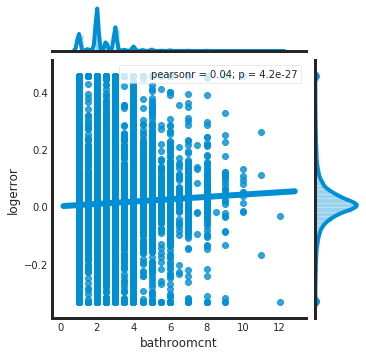

/Users/ddfloww/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


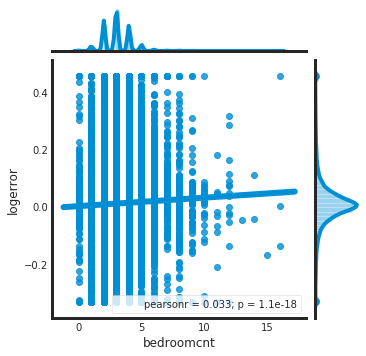

/Users/ddfloww/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


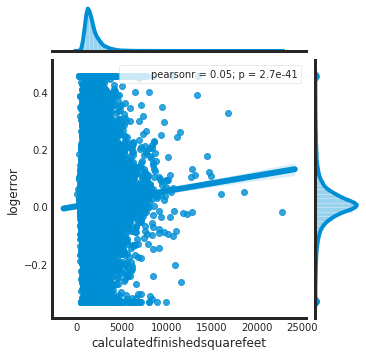

/Users/ddfloww/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


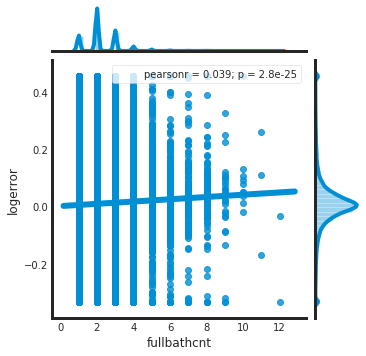

/Users/ddfloww/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


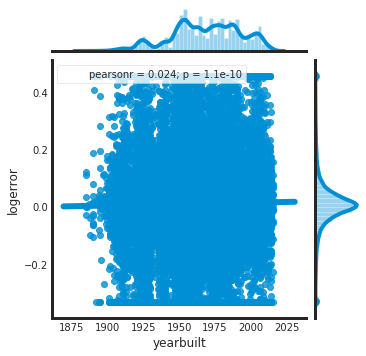

/Users/ddfloww/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


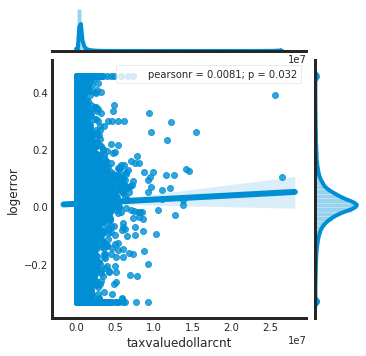

/Users/ddfloww/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


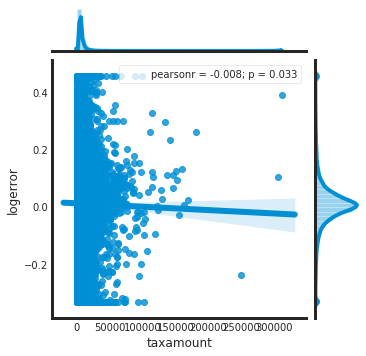

In [22]:
with sns.axes_style('white'):
    j = sns.jointplot('bathroomcnt', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('bedroomcnt', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('calculatedfinishedsquarefeet', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('fullbathcnt', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('yearbuilt', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('taxvaluedollarcnt', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('taxamount', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

#### Create a feature plot using seaborn's PairGrid() of the interaction between each variable (dependent + independent). 

*TODO: use normalized version, time permitting.*

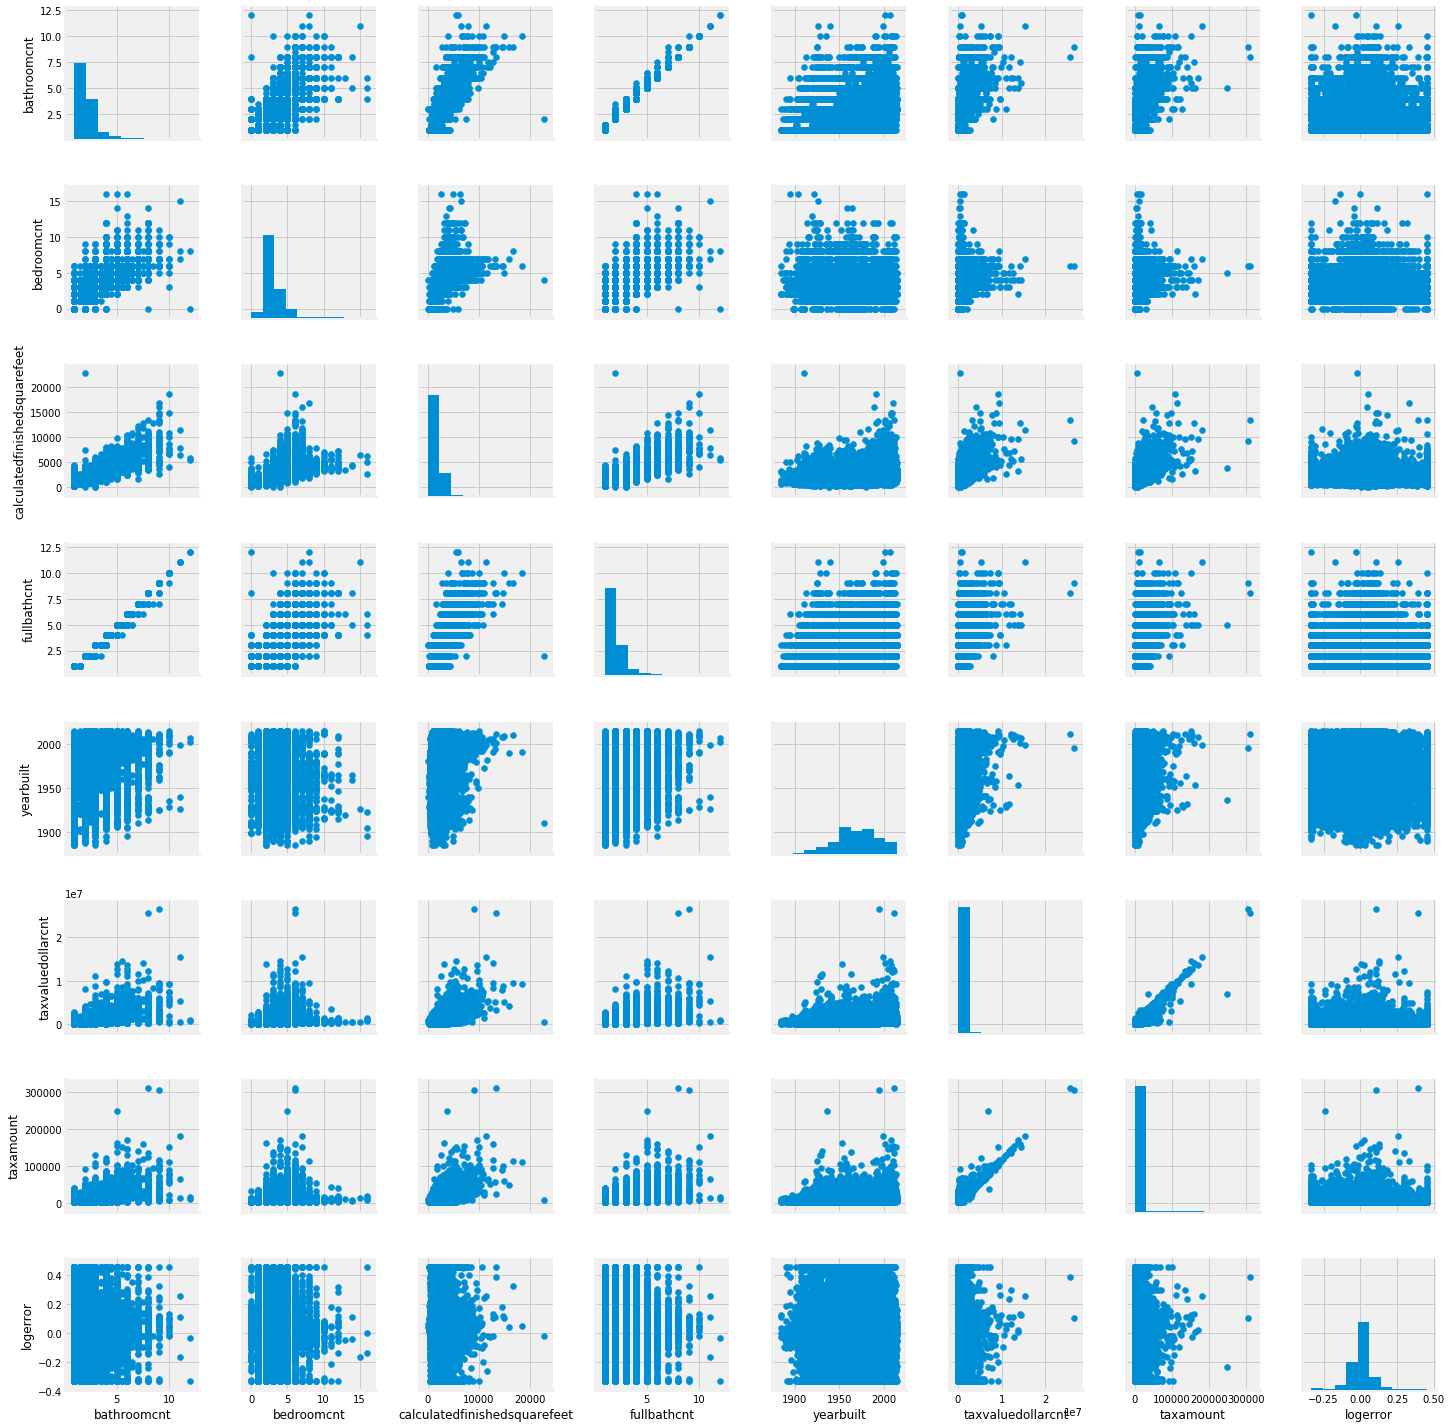

In [23]:
g = sns.PairGrid(train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

#### Create a heatmap of the correlation between each variable pair.

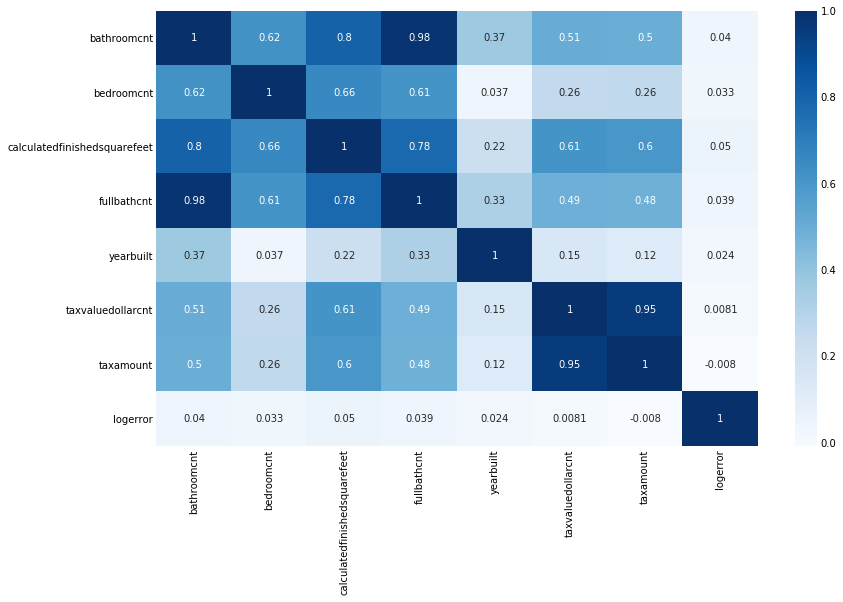

In [24]:
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(), cmap='Blues', annot=True)

#### Summarize your conclusions from all of these steps.  

*TODO: answer this question.*

#### Is the logerror significantly different for homes with 3 bedrooms vs those with 5 or more bedrooms? 
Run a t-test to test this difference.

In [25]:
data_bed_3 = train[train['bedroomcnt'] == 3.0]
data_bed_5 = train[train['bedroomcnt'] >= 5.0]

stat, p = stats.ttest_ind(data_bed_3['logerror'], data_bed_5['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

# if p-value is < 0.05, you can reject the null hypothesis

T-stat: -7.833718484753583
p-value: 4.8742202128198414e-15


#### Do the same for another 2 samples that we are interested in comparing.

In [26]:
data_bath_1 = train[train['bathroomcnt'] == 1.0]
data_bath_2 = train[train['bathroomcnt'] >= 2.0]

stat, p = stats.ttest_ind(data_bath_1['logerror'], data_bath_2['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: -3.792428229185891
p-value: 0.00014930682230782582


In [27]:
data_sq_small = train[train['calculatedfinishedsquarefeet'] < 1300.0]
data_sq_large = train[train['calculatedfinishedsquarefeet'] >= 1300.0]

stat, p = stats.ttest_ind(data_sq_small['logerror'], data_sq_large['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: -7.104626604262173
p-value: 1.2177478517880019e-12


### Data Modeling

#### Feature Engineering & Selection

#### Are there new features you could create based on existing features that might be helpful? 

Come up with at least one possible new feature that is a calculation from 2+ existing variables. 

#### Use statsmodels ordinary least squares to assess the importance of each feature with respect to the target

#### Summarize your conclusions and next steps from your analysis in above. 
What will you try when developing your model? (which features to use/not use/etc)

#### Train & Test Model

#### Fit, predict (in-sample) & evaluate multiple linear regression models to find the best one.

- Make any changes as necessary to improve your model.

- Identify the best model after all training

- Compare the models by plotting the predictions of each model with actual values (see plot right above section 12 in 'Regression in Python' lesson

(the predictions are a 1 x 83 two dimensional matrix, but we want just a single array of predictions. We can use the .ravel method to achieve this.)

`pd.DataFrame({'actual': y_train.final_grade,  
              'lm1': y_pred_lm1.ravel(),  
              'lm2': y_pred_lm2.ravel()})\  
    .melt(id_vars=['actual'], var_name='model', value_name='prediction')\  
    .pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')  

plt.plot([60, 100], [60, 100], c='black', ls=':')  
plt.ylim(60, 100)  
plt.xlim(60, 100)  
plt.title('Predicted vs Actual Final Grade')`  

#### Predict & evaluate on out-of-sample data (test)    

- Plot the residuals from your out-of-sample predictions.

- Summarize your expectations about how you estimate this model will perform in production.

#### Use statsmodels ordinary least squares to assess the importance of each feature with respect to the target

In [28]:
ols_model = sm.OLS(y_train, X_train)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     186.3
Date:                Fri, 22 Mar 2019   Prob (F-statistic):          8.54e-275
Time:                        21:45:24   Log-Likelihood:                 64354.
No. Observations:               71196   AIC:                        -1.287e+05
Df Residuals:                   71189   BIC:                        -1.286e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
bathroomcnt                     -0.0014      0.002     -0.612      0.540      -0.006       0.003
bedroomcnt                      -0.0010      0.000     -2.114      0.035      -0.002   -7.17e-05
calculatedfinishedsquarefeet  8.883e-06   8.01e-07     11.094      0.000    7.31e-06    1.05e-05
fullbathcnt                      0.0017      0.002      0.799      0.424      -0.003       0.006
yearbuilt                     1.175e-06   5.89e-07      1.996      0.046    2.11e-08    2.33e-06
taxvaluedollarcnt             2.506e-08   2.31e-09     10.866      0.000    2.05e-08    2.96e-08
taxamount                    -2.782e-06   1.85e-07    -15.076      0.000   -3.14e-06   -2.42e-06
==============================================================================
Omnibus:                    16379.783   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           133541.867
Skew:                           0.883   Prob(JB):                         0.00
Kurtosis:                       9.473   Cond. No.                     5.94e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.94e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Train & Test Model

In [29]:
# Create linear regression objects
lm1 = LinearRegression()
print(lm1)

lm1.fit(X_train[['calculatedfinishedsquarefeet']], y_train)
print(lm1)

lm1_y_intercept = lm1.intercept_
print(lm1_y_intercept)

lm1_coefficients = lm1.coef_
print(lm1_coefficients)

print()
print('Univariate - log error = b + m1 * square feet')
print('    y-intercept  (b): %.2f' % lm1_y_intercept)
print('    coefficient (m1): %.2f' % lm1_coefficients[0][0])

y_pred_lm1 = lm1.predict(X_train[['calculatedfinishedsquarefeet']])

mse_lm1 = mean_squared_error(y_train, y_pred_lm1)
print("lm1\n  mse: {:.3}".format(mse_lm1)) 

r2_lm1 = r2_score(y_train, y_pred_lm1)

print('  {:.2%} of the variance in the log error can be explained by the number of square feet.'.format(r2_lm1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.00112548]
[[5.34675371e-06]]

Univariate - log error = b + m1 * square feet
    y-intercept  (b): 0.00
    coefficient (m1): 0.00
lm1
  mse: 0.00964
  0.25% of the variance in the log error can be explained by the number of square feet.


In [30]:
# Create linear regression objects
lm2 = LinearRegression()
print(lm2)

lm2.fit(X_train[['bathroomcnt', 'fullbathcnt']], y_train)
print(lm2)

lm2_y_intercept = lm2.intercept_
print(lm2_y_intercept)

lm2_coefficients = lm2.coef_
print(lm2_coefficients)

print()
print('Multivariate - log error = b + m1 * bathroom count + m2 * full bath count')
print('    y-intercept  (b): %.2f' % lm2_y_intercept)
print('    coefficient (m1): %.2f' % lm2_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm2_coefficients[0][1])

y_pred_lm2 = lm2.predict(X_train[['bathroomcnt', 'fullbathcnt']])

mse_lm2 = mean_squared_error(y_train, y_pred_lm2)
print("lm2\n  mse: {:.3}".format(mse_lm2)) 

r2_lm2 = r2_score(y_train, y_pred_lm2)

print('  {:.2%} of the variance in the log error can be explained by the number of bathrooms.'.format(r2_lm2))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.00117777]
[[ 0.00663127 -0.00263744]]

Multivariate - log error = b + m1 * bathroom count + m2 * full bath count
    y-intercept  (b): 0.00
    coefficient (m1): 0.01
    coefficient (m2): -0.00
lm2
  mse: 0.00965
  0.17% of the variance in the log error can be explained by the number of bathrooms.


In [31]:
# Create linear regression objects
lm3 = LinearRegression()
print(lm3)

lm3.fit(X_train[['bedroomcnt']], y_train)
print(lm3)

lm3_y_intercept = lm3.intercept_
print(lm3_y_intercept)

lm3_coefficients = lm3.coef_
print(lm3_coefficients)

print()
print('Multivariate - log error = b + m1 * bedroom count')
print('    y-intercept  (b): %.2f' % lm3_y_intercept)
print('    coefficient (m1): %.2f' % lm3_coefficients[0][0])

y_pred_lm3 = lm3.predict(X_train[['bedroomcnt']])

mse_lm3 = mean_squared_error(y_train, y_pred_lm3)
print("lm3\n  mse: {:.3}".format(mse_lm3)) 

r2_lm3 = r2_score(y_train, y_pred_lm3)

print('  {:.2%} of the variance in the log error can be explained by the number of bedrooms.'.format(r2_lm3))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.00154169]
[[0.00294864]]

Multivariate - log error = b + m1 * bedroom count
    y-intercept  (b): 0.00
    coefficient (m1): 0.00
lm3
  mse: 0.00966
  0.11% of the variance in the log error can be explained by the number of bedrooms.


In [32]:
# Create linear regression objects
lm4 = LinearRegression()
print(lm4)

lm4.fit(X_train[['calculatedfinishedsquarefeet', 'bathroomcnt', 'fullbathcnt', 'bedroomcnt', 'taxvaluedollarcnt', 'taxamount']], y_train)
print(lm4)

lm4_y_intercept = lm4.intercept_
print(lm4_y_intercept)

lm4_coefficients = lm4.coef_
print(lm4_coefficients)

print()
print('Multivariate:')
print('    y-intercept  (b): %.2f' % lm4_y_intercept)
print('    coefficient (m1): %.2f' % lm4_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm4_coefficients[0][1])
print('    coefficient (m1): %.2f' % lm4_coefficients[0][2])
print('    coefficient (m2): %.2f' % lm4_coefficients[0][3])
print('    coefficient (m2): %.2f' % lm4_coefficients[0][4])
print('    coefficient (m2): %.2f' % lm4_coefficients[0][5])

y_pred_lm4 = lm4.predict(X_train[['calculatedfinishedsquarefeet', 'bathroomcnt', 'fullbathcnt', 'bedroomcnt', 'taxvaluedollarcnt', 'taxamount']])

mse_lm4 = mean_squared_error(y_train, y_pred_lm4)
print("lm4\n  mse: {:.3}".format(mse_lm4)) 

r2_lm4 = r2_score(y_train, y_pred_lm4)

print('  {:.2%} of the variance in the log error can be explained by the number of bathrooms.'.format(r2_lm4))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.00220155]
[[ 8.86799865e-06 -1.28704294e-03  1.68627567e-03 -9.71120928e-04
   2.50528213e-08 -2.78172705e-06]]

Multivariate:
    y-intercept  (b): 0.00
    coefficient (m1): 0.00
    coefficient (m2): -0.00
    coefficient (m1): 0.00
    coefficient (m2): -0.00
    coefficient (m2): 0.00
    coefficient (m2): -0.00
lm4
  mse: 0.0096
  0.66% of the variance in the log error can be explained by the number of bathrooms.


#### Model #4 yields the best results of all training models.

#### Fit, predict (in-sample) & evaluate multiple linear regression models to find the best one.

Text(0.5, 1.0, 'Predicted vs Actual Log Error')

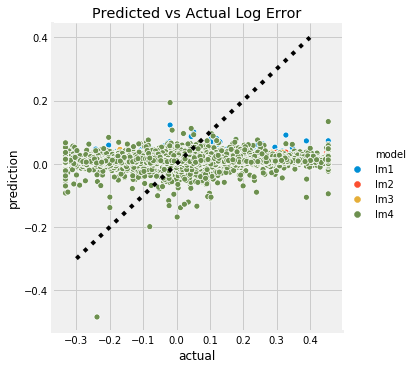

In [33]:
# We want just a single array of predictions. We can use
# the .ravel method to achieve this.

pd.DataFrame({'actual': y_train.logerror,
              'lm1': y_pred_lm1.ravel(),
              'lm2': y_pred_lm2.ravel(),
              'lm3': y_pred_lm3.ravel(),
              'lm4': y_pred_lm4.ravel()
             })\
    .melt(id_vars=['actual'], var_name='model', value_name='prediction')\
    .pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')

plt.plot([-.3, .4], [-.3, .4], c='black', ls=':')
plt.title('Predicted vs Actual Log Error')

#### Predict log errors using testing data

In [34]:
# Make predictions using the testing set
y_pred_lm4 = lm4.predict(X_test[['calculatedfinishedsquarefeet', 'bathroomcnt', 'fullbathcnt', 'bedroomcnt', 'taxvaluedollarcnt', 'taxamount']])

#### Evaluate performance

In [35]:
mse = mean_squared_error(y_test, y_pred_lm4)

print("Mean squared error: %.2f" % mse)

Mean squared error: 0.01


In [42]:
r2 = r2_score(y_test, y_pred_lm4)

print('{:.2%} of the variance in log errors can be explained by calculatedfinishedsquarefeet, bathroomcnt, fullbathcnt, bedroomcnt, taxvaluedollarcnt, taxamount.'
      .format(r2))

1.00% of the variance in log errors can be explained by calculatedfinishedsquarefeet, bathroomcnt, fullbathcnt, bedroomcnt, taxvaluedollarcnt, taxamount.


Text(0, 0.5, 'Residuals')

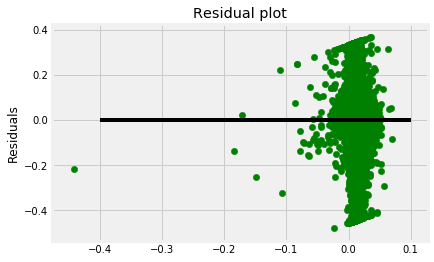

In [43]:
plt.scatter(y_pred_lm4, y_pred_lm4 - y_test, c='g', s=40)
plt.hlines(y=0, xmin=-.4, xmax=.1)
plt.title("Residual plot")
plt.ylabel('Residuals')